In [ ]:
import sys
sys.path.append('..')

# **2.1. - LSTM (*Long Short-Term Memory*) + GloVe (*Global Vectors for Word Representation*)**

In this notebook, we will use the same LSTM model as in the previous notebook (`2-LSTM.ipynb`), but we will use a different word embedding technique. More specifically, instead of using our own word embedding, which is trained from scratch, we will use a pre-trained word embedding technique called GloVe (*Global Vectors for Word Representation*), which were explained in `1.1-RNN+GloVe.ipynb`.

Let's load the required libraries in order to run the code:

In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from src.data_exploration.data_preprocessing import train_test_split, tokenization, load_glove_embeddings, create_embedding_matrix
from src.utils.eval_utils import plot_metric_curves, plot_confusion_matrix

## Load dataset

Let's load the dataset generated in `0-EDA.ipynb`:

In [2]:
dataset = os.path.join("../data", "Sarcasm_Headlines_Dataset_v2.csv")

df = pd.read_csv(dataset, sep=";")
df.head()

,headline,label
0,scientist unveil doomsday clock hair loss,1
1,dem rep totally nail congress falling short ge...,0
2,eat different recipe,0
3,weather prevents liar getting work,1
4,mother come pretty close using word streaming ...,1


## Split data into train and validation sets

We need to generate both training and validation sets. We will use 80% of the data for training and the remaining 20% for validation. Moreover, in classification tasks it is important to maintain the same proportion of classes in both training and validation sets (otherwise, the model might be affected by it during the training process, and the validation metrics may also be distorted). `scikit-learn` offers the class `StratifiedShuffleSplit` for achieving this, which will be used. We have developed the `train_test_split` function, which is stored in `src/data_exploration/data_preprocessing.py`:

In [3]:
X_train, y_train, X_val, y_val = train_test_split(df, "label")

Let's check that the training set contains 80% of data:

In [4]:
np.round(len(X_train) / len(df), 2)

0.8

Let's also check that the distribution of classes in both sets are almost the same:

In [5]:
y_train.value_counts(normalize=True)

label
0    0.518145
1    0.481855
Name: proportion, dtype: float64

In [6]:
y_val.value_counts(normalize=True)

label
0    0.518237
1    0.481763
Name: proportion, dtype: float64

# Tokenization, Padding and Sequencing

In [7]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val, "headline")

## Build the model

In [8]:
num_tokens = vocab_size + 1
# Define embedding dimension for GloVe (this is needed in order to load the corresponding embeddings)
embedding_dim = 100

path_to_glove_file = os.path.join("../data", f"glove.6B.{embedding_dim}d.txt")

In [9]:
embeddings_index = load_glove_embeddings(path_to_glove_file)
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [10]:
embedding_matrix, hits, misses = create_embedding_matrix(embeddings_index, tokenizer, num_tokens, embedding_dim)
print(f"Converted {hits} words ({misses} misses)")

Converted 7532 words (138 misses)


In [11]:
model = Sequential()

# Embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    # input_length=max_seq_len,
    trainable=False,
)

model.add(embedding_layer)

# Add Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

# Output layer
model.add(Dense(1, activation="sigmoid"))

In [12]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         767200    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

## Train the model

Let's first create a folder where to save our models.

In [14]:
# Create directory where to save the models created
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

In [15]:
# Model name and path
model_path = os.path.join(models_dir, "lstm_glove_model.h5")

We use `EarlyStopping` to limit *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training. We will using validation loss as metric function for early stopping, setting a patience of 3 (i.e., we will stop after there is no improvement in validation loss for 3 epochs of training). Since we are dealing with a relatively small dataset, we can set a high enough number of epochs, as we can be fairly sure that training will be stopped before reaching the limit.

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [17]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(val_padded, np.array(y_val)),
    callbacks = [es, mc]
)

Epoch 1/30
337/338 [============================>.] - ETA: 0s - loss: 0.5956 - acc: 0.6753
Epoch 1: val_loss improved from inf to 0.52546, saving model to models\lstm_glove_model.h5
338/338 [==============================] - 58s 107ms/step - loss: 0.5956 - acc: 0.6750 - val_loss: 0.5255 - val_acc: 0.7402
Epoch 2/30
338/338 [==============================] - ETA: 0s - loss: 0.5397 - acc: 0.7228
Epoch 2: val_loss improved from 0.52546 to 0.49627, saving model to models\lstm_glove_model.h5
338/338 [==============================] - 33s 98ms/step - loss: 0.5397 - acc: 0.7228 - val_loss: 0.4963 - val_acc: 0.7626
Epoch 3/30
338/338 [==============================] - ETA: 0s - loss: 0.5135 - acc: 0.7431
Epoch 3: val_loss improved from 0.49627 to 0.46387, saving model to models\lstm_glove_model.h5
338/338 [==============================] - 35s 103ms/step - loss: 0.5135 - acc: 0.7431 - val_loss: 0.4639 - val_acc: 0.7786
Epoch 4/30
337/338 [============================>.] - ETA: 0s - loss: 0.484

## Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

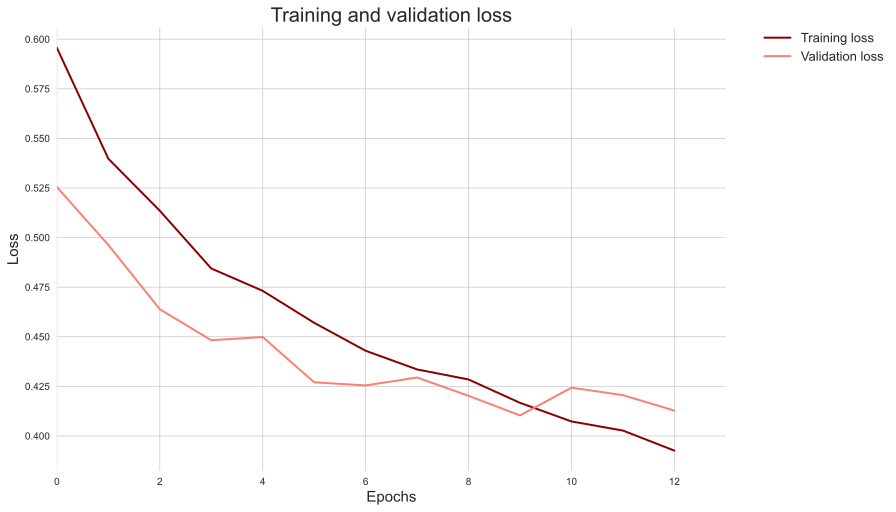

In [19]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkred", "salmon", "Loss", 2)

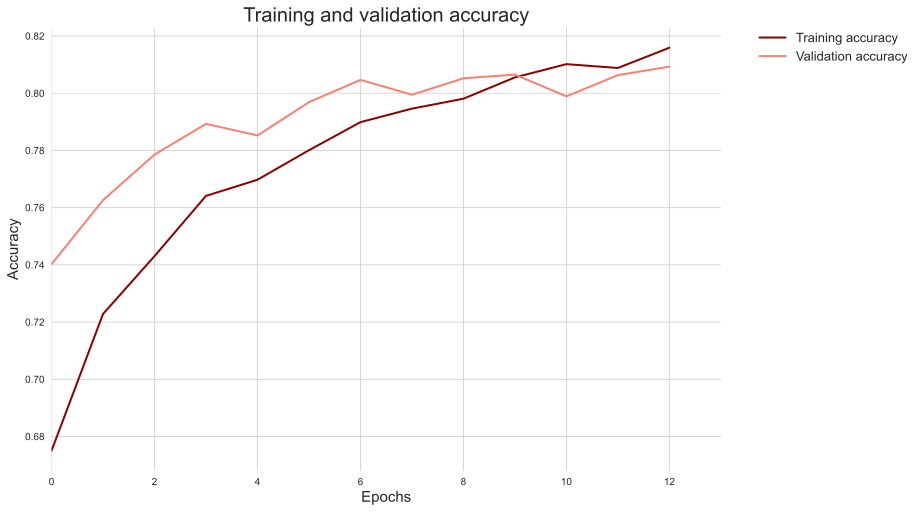

In [20]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkred", "salmon", "Accuracy", 2)

The model appears to learn well until the 9th epoch, at which point it begins to overfit. While the model seems better than the LSTM model using custom word embeddings at first glance, the metrics achieved during the training process are similar. The key difference is that the first model only needed one epoch to reach its best version, while this model needed 9 epochs. The saved model achieved a validation loss of 0.40 and a validation accuracy of 0.81.

## Evaluate model

Let's finally see how well the model performs with unseen data. Firstly, we will load the test set:

In [21]:
test_set = os.path.join("../data", "Sarcasm_Headlines_Dataset_OOS_Prep.csv")
df_test = pd.read_csv(test_set, sep=";")
df_test.head()

,headline,label
0,nextdoor ceo recruit army fanatic holy crusade...,1
1,exclusive interview clarence thomas,1
2,pro con banning book,1
3,know train derailment toxic chemical ohio,1
4,cia criticized use abusive etiquette coach bla...,1


In [22]:
df_test.shape

(2003, 2)

And then we need to create both $X_{test}$ and $y_{test}$:

In [23]:
# Get X_test and y_test
X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

Finally, we need to apply the same preprocessing steps that we applied to the training set (tokenization, padding and sequencing):

In [24]:
# Apply tokenizer to test set
test_sequences = tokenizer.texts_to_sequences(X_test["headline"])
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

Let's also load the best model obtained during training:

In [25]:
lstm_model = load_model(model_path)

We can now evaluate the model with the test set:

In [26]:
# Evaluate model on test set
loss_test, acc_test = lstm_model.evaluate(test_padded, np.array(y_test))
print("Test loss: {:.4f}".format(loss_test))
print("Test accuracy: {:.4f}".format(acc_test))

63/63 [==============================] - 2s 9ms/step - loss: 0.7789 - acc: 0.6251
Test loss: 0.7789
Test accuracy: 0.6251


63/63 [==============================] - 1s 7ms/step


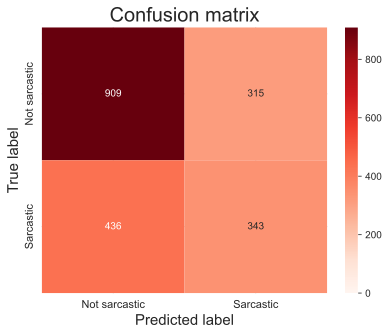

In [27]:
predictions = lstm_model.predict(test_padded)
conf_matrix = confusion_matrix(y_test, np.round(predictions))
plot_confusion_matrix(conf_matrix, ["Not sarcastic", "Sarcastic"], "Reds")

In [28]:
conf_matrix

array([[909, 315],
       [436, 343]], dtype=int64)

In [29]:
print(classification_report(y_test, np.round(predictions)))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1224
           1       0.52      0.44      0.48       779

    accuracy                           0.63      2003
   macro avg       0.60      0.59      0.59      2003
weighted avg       0.62      0.63      0.62      2003



As it is shown in the results, this model is similar to the LSTM model obtained using custom word embeddings.

Comparing the confusion matrix of the GloVe model with the one obtained from the RNN model using GloVe, we observe a similar situation to the one presented in the other LSTM model, with a decrease in the number of False Positives (420 vs 315) while having an increase in the number of false negatives (397 vs 436).